In [1]:
%matplotlib inline
import torch
import torch_directml
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt

# use GPU for computations if possible
device = torch_directml.device() #if torch_directml.is_available() else torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

c:\Users\denaa\anaconda3\envs\pydml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the linear transformation $X W + b$ and then the softmax function to obtain the class probabilities predicted by the model.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.U1 = 4  # Number of filters for the first convolutional layer
        self.U2 = 8  # Number of filters for the second convolutional layer
        self.U3 = 12 # Number of filters for the third convolutional layer
        self.U3_flat = 7*7*self.U3 # Number of neurons in flattened third layer
        self.U4 = 200 # Number of neurons in first dense layer
        self.U5 = 10  # Number of neurons in second dense layer
        
        # First convolutional layer
        self.W1 = nn.Parameter(0.1 * torch.randn(self.U1, 1, 5, 5))
        self.b1 = nn.Parameter(torch.ones(self.U1)/10)
        
        # Second convolutional layer
        self.W2 = nn.Parameter(0.1 * torch.randn(self.U2, self.U1, 5, 5))
        self.b2 = nn.Parameter(torch.ones(self.U2)/10)
        
        # Third convolutional layer
        self.W3 = nn.Parameter(0.1 * torch.randn(self.U3, self.U2, 4, 4))
        self.b3 = nn.Parameter(torch.ones(self.U3)/10)
        
        # First dense layer
        self.W4 = nn.Parameter(0.1 * torch.randn(self.U3_flat, self.U4))
        self.b4 = nn.Parameter(torch.ones(self.U4)/10)
        
        # Second dense layer
        self.W5 = nn.Parameter(0.1 * torch.randn(self.U4, self.U5))
        self.b5 = nn.Parameter(torch.ones(self.U5)/10)

    def forward(self, X):
        # Apply first convolutional layer
        Q1 = F.relu(F.conv2d(X, self.W1, bias=self.b1, stride=1, padding=2))
        
        # Apply second convolutional layer
        Q2 = F.relu(F.conv2d(Q1, self.W2, bias=self.b2, stride=2, padding=2))
        
        # Apply third convolutional layer
        Q3 = F.relu(F.conv2d(Q2, self.W3, bias=self.b3, stride=2, padding=1))
        
        # Flatten the third convolutional layer
        Q3_flat = Q3.view(-1, self.U3_flat)
        
        # Apply first dense layer
        Q4 = F.relu(Q3_flat.mm(self.W4) + self.b4)
        
        # Apply second dense layer
        Z = Q4.mm(self.W5) + self.b5
        
        return Z


## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [4]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y]

    return -(Y_onehot * G.log()).sum(dim = 1).mean()

The next lines evaluate the accuracy of the predictions.

In [5]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [6]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
# learningrate = 0.003
# optimizer = optim.Adam(net.parameters(), lr=learningrate)
gamma_max = 0.003
gamma_min = 0.0001
optimizer = optim.Adam(net.parameters(), lr=gamma_max)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 10000 # total number of iterations
t = 0 # current iteration

done = False
while not done:
    
    gamma = gamma_min + (gamma_max - gamma_min) * np.exp(-t / 2000)
    for p in optimizer.param_groups:
        p['lr'] = gamma
    
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        # loss = crossentropy(batch_G, batch_Y)
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()
        
        # perform gradient descent step
        optimizer.step()
        
        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)
                
            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(F.cross_entropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")
            
        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break
        


Step     0: train accuracy  14.00% train cross-entropy  2.34  test accuracy  11.96% test cross-entropy  2.30
Step   100: train accuracy  96.00% train cross-entropy  0.13  test accuracy  93.55% test cross-entropy  0.22
Step   200: train accuracy  99.00% train cross-entropy  0.05  test accuracy  95.59% test cross-entropy  0.14
Step   300: train accuracy  97.00% train cross-entropy  0.09  test accuracy  95.86% test cross-entropy  0.13
Step   400: train accuracy  98.00% train cross-entropy  0.08  test accuracy  96.72% test cross-entropy  0.10
Step   500: train accuracy  98.00% train cross-entropy  0.07  test accuracy  97.83% test cross-entropy  0.07
Step   600: train accuracy  96.00% train cross-entropy  0.11  test accuracy  98.05% test cross-entropy  0.06
Step   700: train accuracy  98.00% train cross-entropy  0.07  test accuracy  98.00% test cross-entropy  0.06
Step   800: train accuracy  95.00% train cross-entropy  0.16  test accuracy  97.74% test cross-entropy  0.06
Step   900: train a

## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

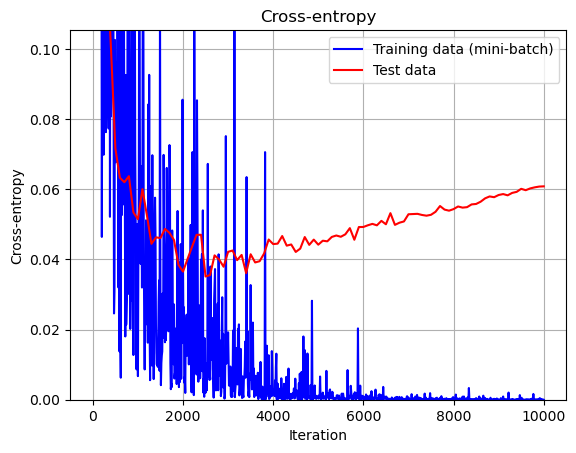

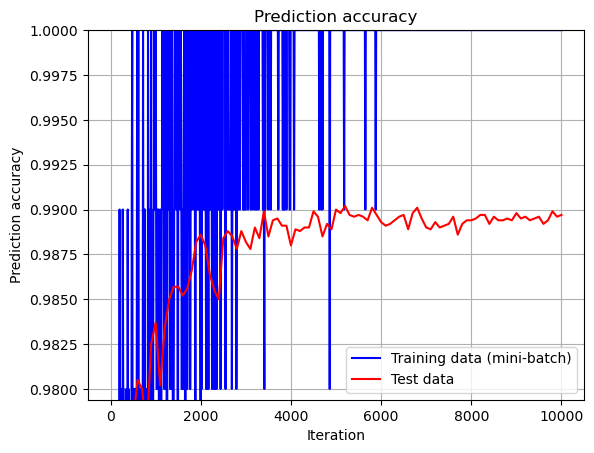

In [7]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

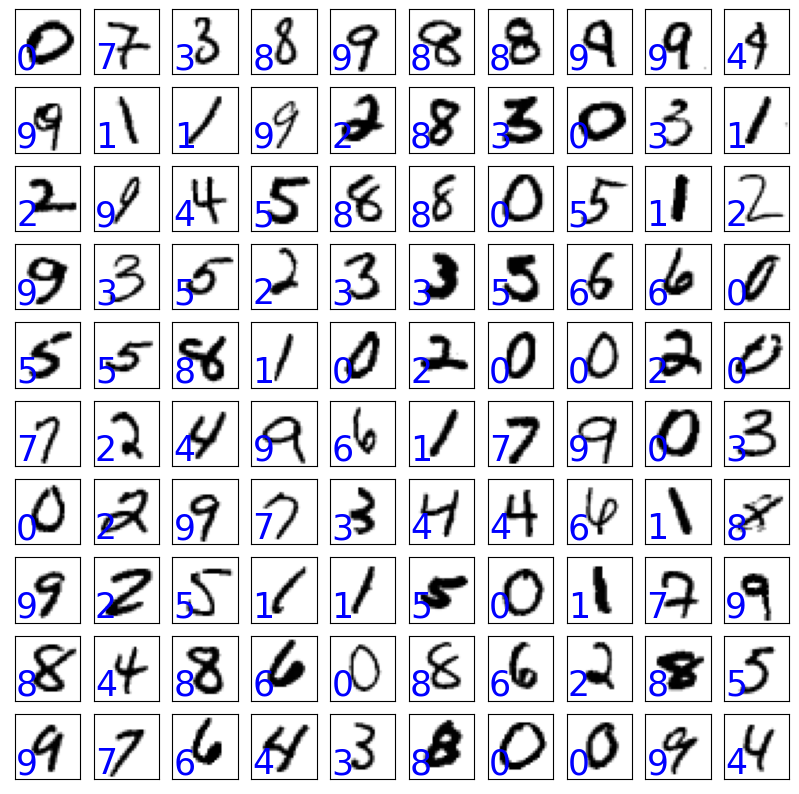

In [8]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))
    
    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)
    
    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    
    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)
    
    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)
        
plt.show()